# Preparing the corpus

In [3]:
# hide jupyter warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [5]:
import pyLDAvis
import pyLDAvis.gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

/anaconda/envs/pfe-env/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [6]:
df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)
#df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# remove duplicates 
# 840 tweets had been droped

df = df[df['lang'] == 'fr']
df = df.sort_values("content") 
  
# dropping ALL duplicte values 
df = df.drop_duplicates(subset ="content", keep = 'first')

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = df['content']

keywords = ['stockage', 'écran', 'ecran', 'autonomie', 'réseau',
            'reseau', 'alimentation',
           'appareil', 'appareil photo', 'processeur', 'multimédia', 
            'multimedia', 'résolution', 'resolution',
           'batterie', 'os', 'pièces', 'pieces' , 'couleur',
           'communication', 'sans fil', 'synchronisation', 'coloris', 
            'poids', 'système', 'systeme',
           'dimensions', 'prix', 'service', 'client', 'support', 'payement']

data = data[data.str.contains('|'.join(keywords), case=False)]

# supprimer les tweets inutiles (publicité, concours ..)

ads_words = [
    '#concours', '#jeuconcours', '#giveaway', 'gagner'
    '#gagne' ,'#gangner', '#promo', '#promotion', '#publicité',
    '#contest', '#ad', '#pub', '#réduction', '#vote', 'votez', 'vote']

data = data[~data.str.contains('|'.join(ads_words), case=False)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import re
import json
from html.parser import HTMLParser
from io import StringIO

import demoji
demoji.download_codes()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


... OK (Got response in 0.39 seconds)
Writing emoji data to /home/azureuser/.demoji/codes.json ...
... OK


In [10]:
class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()
        
def html_free_text(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def emoji_free_text(text):
    return demoji.replace(text, '').strip()

def url_free_text(text):
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)
    return text
    
with open('../input/abrivot_fr.json', encoding='utf-8') as f:
        abrivot = json.load(f)    
def free_abrivot_text(text):
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
%%time

data_free_html = data.apply(html_free_text)
data_free_emoji = data_free_html.apply(emoji_free_text)
data_free_url = data_free_emoji.apply(url_free_text)
data_free_abrivot = data_free_url.apply(free_abrivot_text)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 8.96 s, sys: 0 ns, total: 8.96 s
Wall time: 8.95 s


In [13]:
# Build the bigram and trigrams

data = list(data_free_abrivot)

bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# define a preprocessing function

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# get stopwords
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words = nlp.Defaults.stop_words.union(fr_stopwords)


# final preprocesser
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3, max_len=20) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
%%time

data_ready = process_words(data)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 40.8 s, sys: 46.8 ms, total: 40.8 s
Wall time: 40.9 s


In [16]:
# create the Dictionary

id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 4514


In [17]:
# create the corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


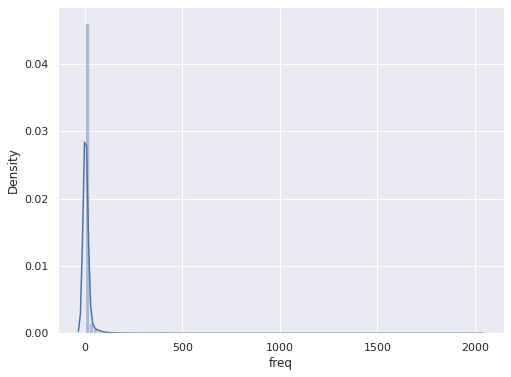

In [19]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [20]:
dict_df.sort_values('freq', ascending=False).head(10)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,freq
max,2013
iphone,1671
prix,1570
batterie,1394
pro,1021
apple,854
photo,830
mini,816
protection,512
euro,488


In [21]:
threshold = 1600
extension = dict_df[dict_df.freq>threshold].index.tolist()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually

extension.append('apple')
extension.append('appl')

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# add high frequency words to stop words list
stop_words.update(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 4302


In [25]:
# Filter extreme words
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.

id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 584


In [26]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Building the LDA Model

Download the LDA mallet from `!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip`  
Extract the model `!unzip mallet-2.0.8.zip`

In [25]:
mallet_path = '../packages/mallet-2.0.8/bin/mallet'

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
# using 10 topics as a start
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=33, id2word=id2word)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(7,
  [('propose', 0.06817090734517522),
   ('smartphone', 0.0585693710993759),
   ('forfaire', 0.05808929428708593),
   ('plan', 0.04896783485357657),
   ('reseau', 0.04752760441670667),
   ('smartphon', 0.04320691310609698),
   ('chute', 0.03408545367258761),
   ('bouygue', 0.033605376860297645),
   ('grosse', 0.030724915986557848),
   ('operateur', 0.030244839174267884)]),
 (15,
  [('chose', 0.13945409429280398),
   ('attendre', 0.08138957816377171),
   ('payer', 0.062034739454094295),
   ('changer', 0.05756823821339951),
   ('cout', 0.054094292803970226),
   ('utiliser', 0.054094292803970226),
   ('falloir', 0.04119106699751861),
   ('devoir', 0.03672456575682382),
   ('presque', 0.028287841191066997),
   ('base', 0.023325062034739455)]),
 (20,
  [('grand', 0.16191832858499525),
   ('photo', 0.12773029439696107),
   ('video', 0.09734093067426401),
   ('mode', 0.06647673314339982),
   ('camer', 0.05318138651471985),
   ('lidar', 0.04843304843304843),
   ('capteur', 0.04653371320037

In [97]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.4155554803506449


In [98]:
# save the model for later

#import pickle
pickle.dump(ldamallet, open("../saved models/ldamallet.pkl", "wb"))

# load the model
#ldamallet = pickle.load(open("../saved models/ldamallet.pkl", "rb"))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
# distribution of topics for each document

tm_results = ldamallet[corpus]

# We can get the most dominant topic of each document as below:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
# get most probable words for the given topicis

topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# create a dataframe for term-topic matrix:

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31,Topic 32,Topic 33
Term1,prendre,apple,chargeur,photo,ecran,apple,batterie,propose,falloir,accessoire,...,vouloir,bonjour,ecran,mac,jour,telephone,question,couleur,batterie,acheter
Term2,jamais,modele,fil,appareil,generation,mettre,composant,smartphone,vendre,coque,...,tech,command,appleevent,igeneration,apple,autonomie,coup,bleu,petit,aller
Term3,reparation,pouce,charge,qualit,probleme,fin,problem,forfaire,difference,protection,...,heure,arrive,oled,magsafe,disponible,portable,gros,noir,incroyable,rir
Term4,system,compatible,rapide,information,shield,gros,appl,plan,ecouteur,coqu,...,mobile,impossible,taille,vie,mise,face,trouve,blanc,stockage,mort
Term5,achete,devoile,recharge,vision,officiel,annee,penurie,reseau,voi,support,...,prefere,site,autonomie,carte,appl,demande,vite,choisir,capacite,donne


In [102]:
# another option

# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Terms per Topic
Topic1,"prendre, jamais, reparation, system, achete, mond, pay, arriver, gosse, autant, possibilite, genre, complet, travail, finalement, daron, outil, final, veulent, connaitre"
Topic2,"apple, modele, pouce, compatible, devoile, homepod, technologie, annonce, offrir, serie, important, presente, annoncer, appleevent, commande, info, long, standard, disponibilite, scanner"
Topic3,"chargeur, fil, charge, rapide, recharge, magsaf, magnetiqu, voiture, usb, magsafe, compatible, article, dommage, cabl, malheureusement, reseal, secteur, prennent, uniquement, adaptateur"
Topic4,"photo, appareil, qualit, information, vision, coloris, dolby, hdr, condition, filmer, capable, courir, puce, partage, flou, retouche, photographe, devoiler, enregistrement, remplir"
Topic5,"ecran, generation, probleme, shield, officiel, resistant, fonds, fond, quatriem, jaune, resister, ceramic, luminosit, tactile, ios, effectivement, envier, logiciel, expliquer, displaymate"
Topic6,"apple, mettre, fin, gros, annee, baisse, vente, terme, appleiphon, actuellement, succe, minute, orlm, orlmac, yvesludwing, iweeklser, baiss, depart, americain, vivement"
Topic7,"batterie, composant, problem, appl, penurie, iphoneaddict, demontage, appareils, montre, devoil, anker, externe, defaut, propre, vieux, debut, predecesseur, travailler, ifixit, actuapplefred"
Topic8,"propose, smartphone, forfaire, plan, reseau, smartphon, chute, bouygue, grosse, operateur, grac, orange, achat, remise, lieu, amazon, reduction, presse, profiter, presentation"
Topic9,"falloir, vendre, difference, ecouteur, voi, argent, boite, penser, valoir, regarde, balle, comprendre, airpod, interet, classique, jamais, gauche, recuperer, chang, voila"
Topic10,"accessoire, coque, protection, coqu, support, etui, jcsatana, selection, bluetooth, batterie, choqu, retir, bref, solde, normal, horrible, crise, autant, ram, depenser"


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


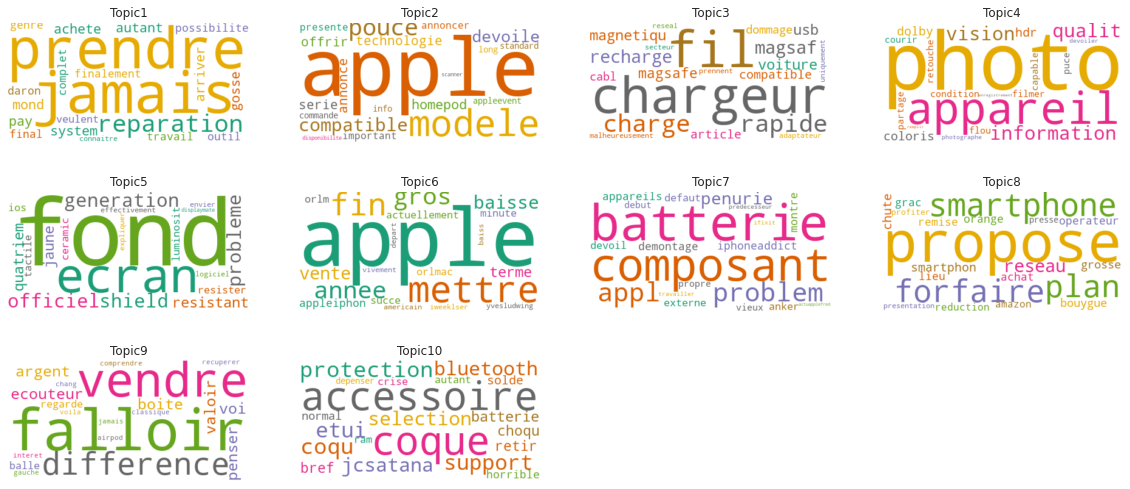

In [103]:
# worldcloud

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [104]:
# visiualize with pyLDAvis
# the mallet model must be converted to a gensim lda model

from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldagensim = convertldaMalletToldaGen(ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis.gensim as gensimvis

vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Dominant Topics for Each Document


In [49]:
# create a dataframe
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Tweet_id'] = data_free_abrivot.index
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,19381,2,12.96,"apple, jour, telephone, propose, composant, venir, telephon, mise, forfaire, devoile, gamme, demande, portable, format, soir, haut, vouloir, penurie, production, vente"
1,6029,2,15.79,"apple, jour, telephone, propose, composant, venir, telephon, mise, forfaire, devoile, gamme, demande, portable, format, soir, haut, vouloir, penurie, production, vente"
2,11631,3,15.62,"appl, chargeur, fil, smartphone, samsung, charge, rapide, compatible, magsafe, igeneration, vendre, galaxy, recharge, ecouteur, plan, magsaf, technologie, magnetiqu, voiture, note"
3,2833,4,16.36,"batterie, accessoire, coque, protection, coqu, support, etui, jcsatana, selection, bluetooth, carte, cuir, vouloir, porte, app, rhinoshield, idee, prefere, nrj, ami"
4,32661,7,12.96,"autonomie, disponible, modele, meilleur, test, oled, mieux, rir, mort, problem, tech, arrive, generation, impossible, bonjour, mobile, rapport, vite, smartphon, heure"


We can use pandas groupby function on “Dominant Topic” column and get the document counts for each topic and its percentage in the corpus with chaining agg function.

In [53]:
# Documents distribution ovec topics

dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,2066,15.04
1,2,1426,10.38
2,3,1525,11.10
3,4,1213,8.83
4,5,1163,8.47
5,6,1408,10.25
6,7,1243,9.05
7,8,1013,7.38
8,9,1308,9.52
9,10,1370,9.97


In [54]:
# the most dominant document per topic

corpus_topic_df.groupby('Dominant Topic').\
    apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,44832,1,25.04,"falloir, mac, sortir, video, savoir, sortie, apple, question, precommand, date, camer, probleme, reseau, utiliser, lidar, octobre, homepod, capteur, keynote, besoin"
1,11058,2,26.39,"apple, jour, telephone, propose, composant, venir, telephon, mise, forfaire, devoile, gamme, demande, portable, format, soir, haut, vouloir, penurie, production, vente"
2,2353,3,27.24,"appl, chargeur, fil, smartphone, samsung, charge, rapide, compatible, magsafe, igeneration, vendre, galaxy, recharge, ecouteur, plan, magsaf, technologie, magnetiqu, voiture, note"
3,36569,4,28.65,"batterie, accessoire, coque, protection, coqu, support, etui, jcsatana, selection, bluetooth, carte, cuir, vouloir, porte, app, rhinoshield, idee, prefere, nrj, ami"
4,2041,5,34.78,"euro, petit, grand, meilleur, appleevent, mois, offrir, super, noir, mode, pouce, offre, bel, version, face, rouge, processeur, nuit, achat, blanc"
5,64482,6,20.63,"acheter, chose, voir, vraiment, passer, attendre, semaine, main, command, partir, pixel, changer, recu, demain, moment, normal, service, commander, aim, espere"
6,11955,7,23.97,"autonomie, disponible, modele, meilleur, test, oled, mieux, rir, mort, problem, tech, arrive, generation, impossible, bonjour, mobile, rapport, vite, smartphon, heure"
7,36068,8,31.82,"faire, pouvoir, mettre, client, cadeau, lien, eter, fin, acheter, baisser, recevoir, payer, aider, gagner, site, aliexpres, surprise, partager, bonjour, veux"
8,35350,9,24.01,"photo, prendre, appareil, oui, achete, difference, vrai, mal, jamais, incroyable, qualit, niveau, trouve, compte, donne, vouloir, hier, cote, devoir, temps"
9,44493,10,25.40,"ecran, couleur, gros, bleu, taille, ipad, coup, air, cout, aller, reparation, verre, shield, casser, attention, couter, grave, bord, impression, donner"


# Conclusion
- Find the proper number of topics
- Delete the verbs

# Finding the optimal number of topics

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
%%time

# Considering 10-70 topics, as the last is cut off
num_topics = list(range(10, 60, 3)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 35min 31s, sys: 344 ms, total: 35min 31s
Wall time: 35min 31s


In [29]:
# Now create a function to derive the Jaccard similarity of two topics:

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Use the above to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# calculate the coherence value with the built in gensim

coherences = [CoherenceModel(model=LDA_models[i], texts=data_ready, dictionary=id2word, coherence='c_v').get_coherence() for i in num_topics[:-1]]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics:

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [ ]:
# Finally graph these metrics across the topic numbers:

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

Your ideal number of topics will maximize coherence and minimize the topic overlap based on Jaccard similarity, in this case it's 33.